# Saving and loading models

In this notebook we demonstrate how to save `SuperScreen` models to disk and load them back into memory for further analysis.

Below we make heavy use of the [tempfile.TemporaryDirectory](https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory) class from the Python standard library to create and automatically clean up directories. Any place you see

```python
with tempfile.TemporaryDirectory() as directory:
    ...
```
you would normally instead define an explicit path, e.g.

```python
directory = "superscreen_results/solutions"
```

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import inspect
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16

import superscreen as sc
from superscreen.geometry import box, circle

A few helper functions to help us visualize how `SuperScreen` objects are saved. 

In [2]:
def tree(
    dir_path: Path,
    prefix: str="",
    space: str ="    ",
    branch: str = "│   ",
    tee: str = "├── ",
    last: str = "└── "
):
    """https://stackoverflow.com/a/59109706/11655306
    
    A recursive generator, given a directory Path object
    will yield a visual tree structure line by line
    with each line prefixed by the same characters.
    """    
    contents = sorted(dir_path.iterdir())
    # contents each get pointers that are ├── with a final └── :
    pointers = [tee] * (len(contents) - 1) + [last]
    for pointer, path in zip(pointers, contents):
        yield prefix + pointer + path.name
        if path.is_dir(): # extend the prefix and recurse:
            extension = branch if pointer == tee else space 
            # i.e. space because last, └── , above so no more |
            yield from tree(path, prefix=prefix + extension)
            
def print_tree(dir_path: Path, prefix: str = ""):
    """Prints out visual representation of a directory tree."""
    for line in tree(dir_path, prefix=prefix):
        print(line)
        
def get_size(dir_path: Path):
    """Gets the total size of a directory in bytes."""
    return sum(file.stat().st_size for file in Path(dir_path).rglob("*"))

def print_doc(method: callable):
    """Prints the signature and docstring of a function or method."""
    name = method.__qualname__
    print(f"{name}{inspect.signature(method)}:")
    print("\n  " + "\n  ".join(method.__doc__.splitlines()))

Generate a sample `Device` to use for these examples:

In [3]:
def make_device(radius: float = 5.0, length_units: str = "um"):
    """Makes a simple device with two layers."""
    layers = [
        sc.Layer("layer0", Lambda=sc.Constant(2.0), z0=0),
        sc.Layer("layer1", Lambda=sc.Constant(0.5), z0=1),
    ]
    films = [
        sc.Polygon("disk", layer="layer0", points=circle(radius)),
        sc.Polygon("square", layer="layer1", points=box(radius)),
    ]
    abstract_regions = [
        sc.Polygon("bounding_box", layer="layer0", points=circle(1.25 * radius)),
    ]
    return sc.Device(
        "device",
        layers=layers,
        films=films,
        abstract_regions=abstract_regions,
        length_units=length_units,
    )

In [4]:
device = make_device()
device.make_mesh(min_points=4000, optimesh_steps=20)

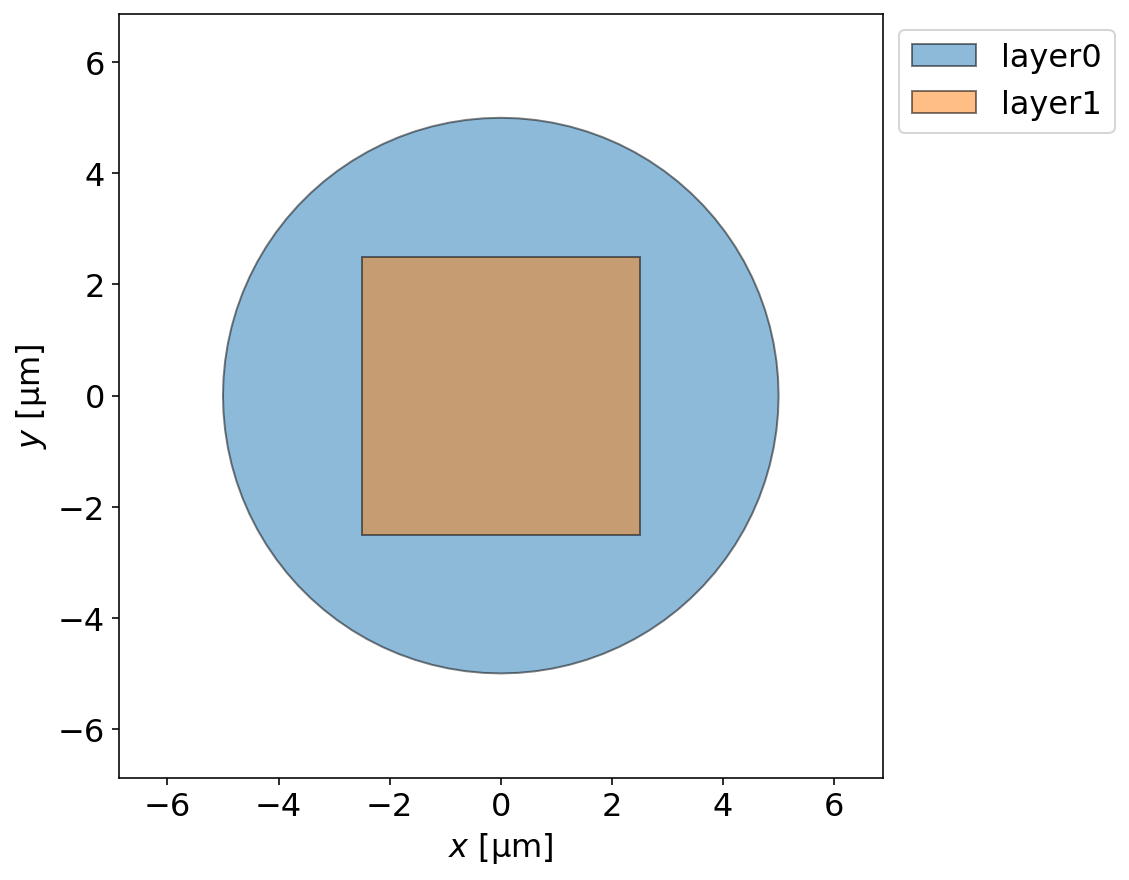

In [5]:
fig, axes = device.draw(exclude="bounding_box", legend=True)

## Device I/O

A single `Device` instance can be saved to disk using the `superscreen.Device.to_file()` method. A saved `Device` consists of a standalone directory with JSON files specifying the device's `polygons` and `layers`, and a `numpy` `npz` file containing the device's mesh (if the option `save_mesh=True` is provided). If a layer's penetration depth, `layer.Lambda` or `layer.london_lambda`, is a `superscreen.Parameter` (as opposed to a Python `int` or `float`), then it is saved in the `dill` binary format.

In [6]:
print_doc(sc.Device.to_file)

Device.to_file(self, directory: str, save_mesh: bool = True, compressed: bool = True) -> None:

  Serializes the Device to disk.
  
          Args:
              directory: The name of the directory in which to save the Device
                  (must either be empty or not yet exist).
              save_mesh: Whether to save the full mesh to file.
              compressed: Whether to use numpy.savez_compressed rather than numpy.savez
                  when saving the mesh.
          


A new `Device` can be created from file using the class method `superscreen.Device.from_file()`.

In [7]:
print_doc(sc.Device.from_file)

Device.from_file(directory: str, compute_matrices: bool = False) -> 'Device':

  Creates a new Device from one serialized to disk.
  
          Args:
              directory: The directory from which to load the device.
              compute_matrices: Whether to compute the field-independent
                  matrices for the device if the mesh already exists.
  
          Returns:
              The loaded Device instance
          


In [8]:
for save_mesh, compressed in [(False, False), (True, False), (True, True)]:
    with tempfile.TemporaryDirectory() as directory:
        header = f"save_mesh = {save_mesh}, compressed = {compressed}:"
        print(header + "\n" + "-" * len(header))
        
        # Save the Device to disk:
        device.to_file(directory, save_mesh=save_mesh, compressed=compressed)
        print(f"{device.name}/")
        
        # Print resulting directory tree and size:
        print_tree(Path(directory))
        directory_size_KB = get_size(directory) / 1024 ** 1
        print(f"{directory_size_KB = :.1f} KB")

        # Load the Device from disk and compar to the original:
        print(
            f"(sc.Device.from_file(directory) == device) = "
            f"{sc.Device.from_file(directory) == device}\n"
        )

save_mesh = False, compressed = False:
--------------------------------------
device/
├── layer0_constant.dill
├── layer1_constant.dill
├── layers.json
└── polygons.json
directory_size_KB = 33.7 KB
(sc.Device.from_file(directory) == device) = True

save_mesh = True, compressed = False:
-------------------------------------
device/
├── layer0_constant.dill
├── layer1_constant.dill
├── layers.json
├── mesh.npz
└── polygons.json
directory_size_KB = 288.4 KB
(sc.Device.from_file(directory) == device) = True

save_mesh = True, compressed = True:
------------------------------------
device/
├── layer0_constant.dill
├── layer1_constant.dill
├── layers.json
├── mesh.npz
└── polygons.json
directory_size_KB = 138.5 KB
(sc.Device.from_file(directory) == device) = True



## Solution I/O

Individual `superscreen.Solution` objects can be saved to disk using `superscreen.Solution.to_file()`.

In [9]:
print_doc(sc.Solution.to_file)

Solution.to_file(self, directory: str, save_mesh: bool = True, compressed: bool = True, to_zip: bool = False) -> None:

  Saves a Solution to disk.
  
          Args:
              directory: The name of the directory in which to save the solution
                  (must either be empty or not yet exist).
              save_mesh: Whether to save the device mesh.
              compressed: Whether to use numpy.savez_compressed rather than numpy.savez.
              to_zip: Whether to save the Solution to a zip file.
          


A `Solution` can also be created/loaded from disk using the class method `superscreen.Solution.from_file()`.

In [10]:
print_doc(sc.Solution.from_file)

Solution.from_file(directory: str, compute_matrices: bool = False) -> 'Solution':

  Loads a Solution from file.
  
          Args:
              directory: The directory from which to load the solution.
              compute_matrices: Whether to compute the field-independent
                  matrices for the device if the mesh already exists.
  
          Returns:
              The loaded Solution instance
          


Let's generate a set of `Solutions` and see how we can save them.

In [11]:
solutions = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(1),
    field_units="mT",
    current_units="mA",
    iterations=3,
)
print(f"len(solutions) = {len(solutions)}")

INFO:superscreen.solve:Calculating layer0 response to applied field.
INFO:superscreen.solve:Calculating layer1 response to applied field.
INFO:superscreen.solve:Caching 1 layer-to-layer kernel(s) (131 MB total) in memory.
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (3/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (3/3).


len(solutions) = 4


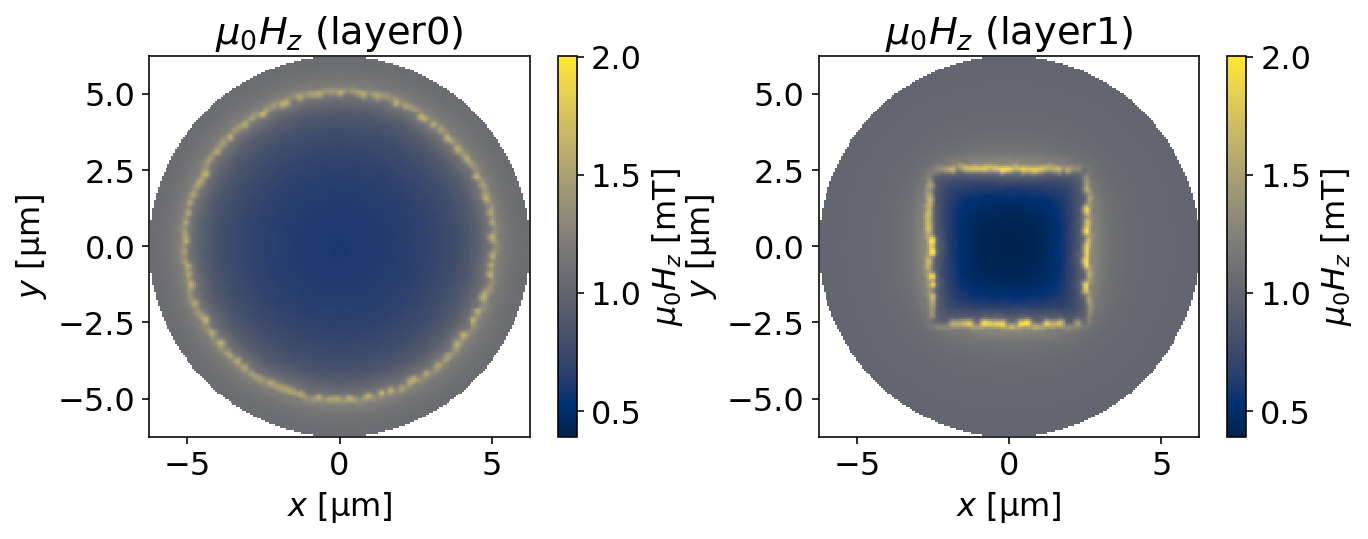

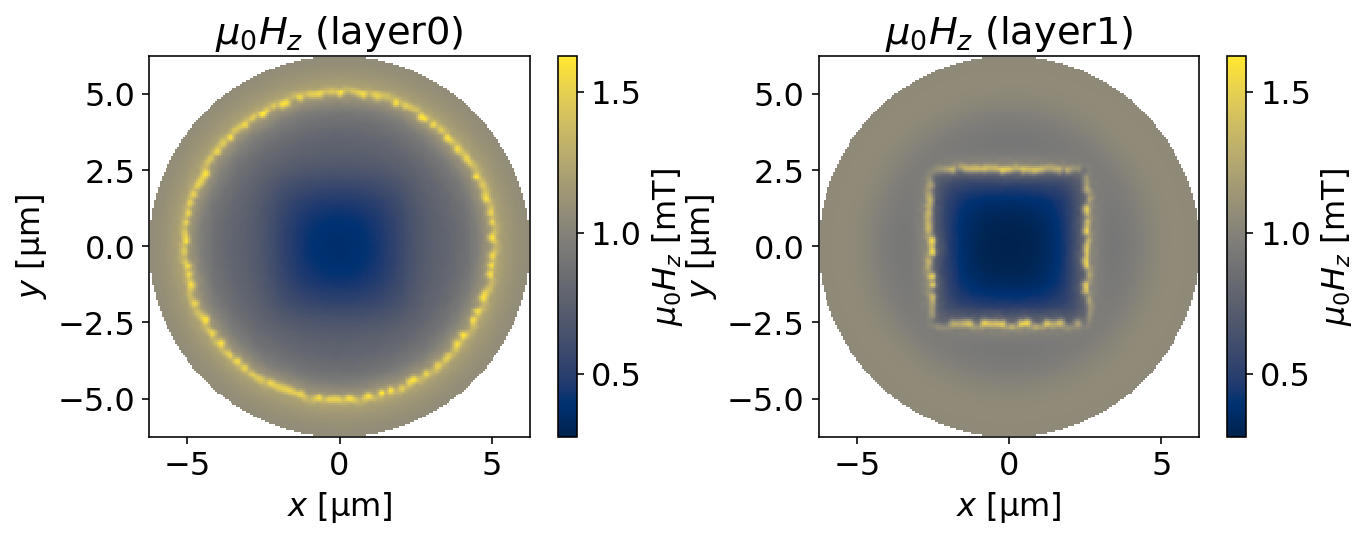

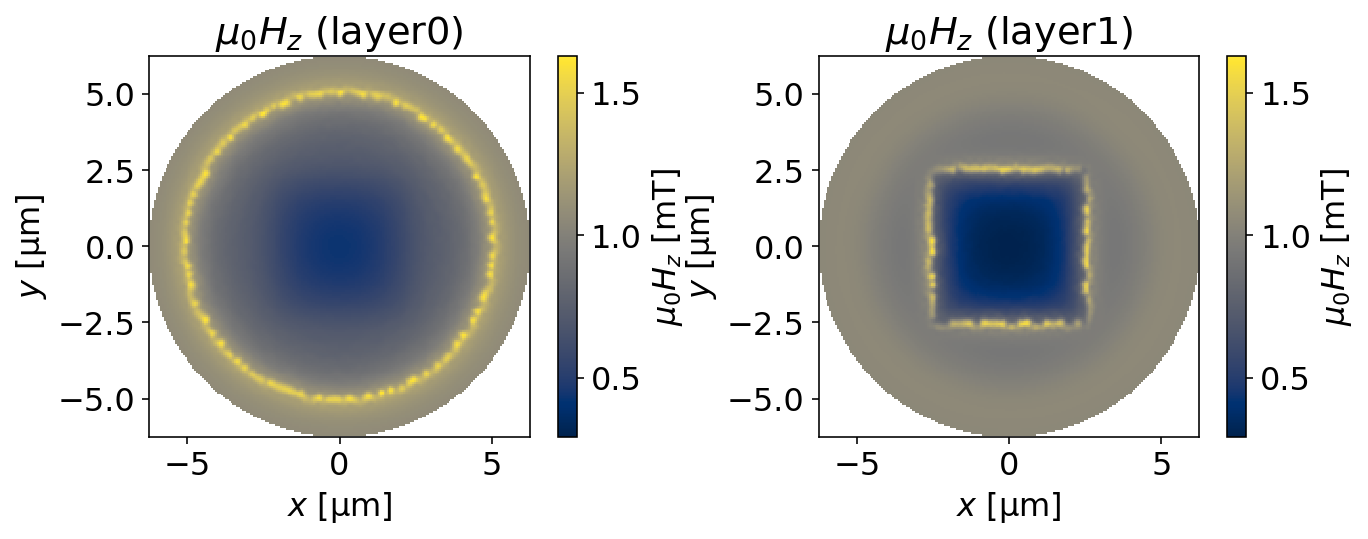

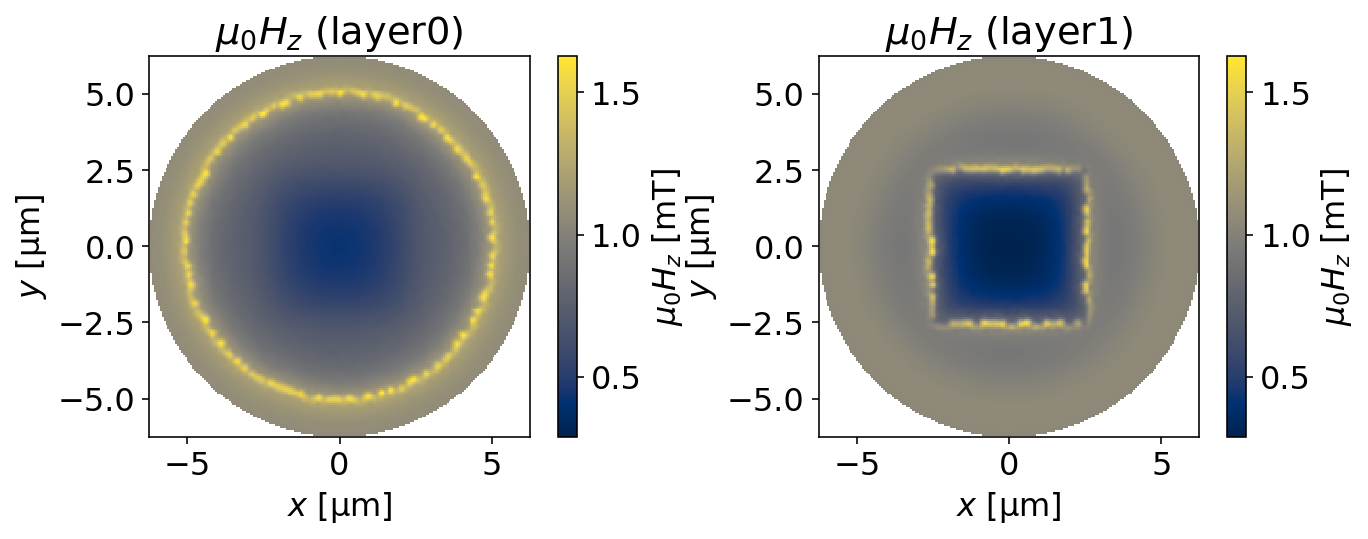

In [12]:
for solution in solutions:
    fig, axes = solution.plot_fields(figsize=(11, 3.5), share_color_scale=True)

In [13]:
for to_zip in [False, True]:
    with tempfile.TemporaryDirectory() as directory:
        header = f"to_zip = {to_zip}:"
        print(header + "\n" + "-" * len(header))
        path = os.path.join(directory, "solution")
        # Save the Solution to disk:
        solutions[-1].to_file(path, to_zip=to_zip)
        # Print resulting directory tree and size:
        if to_zip:
            path += ".zip"
            print("solution.zip")
            directory_size_KB = os.stat(path).st_size / 1024 ** 1
        else:
            print(f"solution/")
            print_tree(Path(path))
            directory_size_KB = get_size(path) / 1024 ** 1
        print(f"{directory_size_KB = :.1f} KB")
        # Load the Solution from disk and compare to the original:
        print(
            f"(sc.Solution.from_file(path) == solutions[-1]) = "
            f"{(sc.Solution.from_file(path) == solutions[-1])}\n"
        )

to_zip = False:
---------------
solution/
├── applied_field.dill
├── device
│   ├── layer0_constant.dill
│   ├── layer1_constant.dill
│   ├── layers.json
│   ├── mesh.npz
│   └── polygons.json
├── layer0_arrays.npz
├── layer1_arrays.npz
└── metadata.json
directory_size_KB = 288.2 KB
(sc.Solution.from_file(path) == solutions[-1]) = True

to_zip = True:
--------------
solution.zip
directory_size_KB = 257.5 KB
(sc.Solution.from_file(path) == solutions[-1]) = True



We can see that when `to_zip` is `False`, the `Solution` is saved in its own directory, with the `Device` as a subdirectory. The applied field, a `superscreen.Parameter`, is saved in the `dill` binary format, the numeric results (stream function, screening field, and total field for each layer) are saved in the `numpy` `npz` format, and extra metadata is saved as JSON.

If `to_zip` is `True`, then the whole directory gets compressed into a single `zip` archive. This can save disk space and make it easy to share results with others.

### Saving and loading multiple `Solutions`

Because `superscreen.solve()` returns a `list` of `superscreen.Solution` objects, it is convenient to be able to save/load all solutions in a single command. Each `Solution` is saved in its own subdirectory whose name is the index of the corresponding `Solution` in the original `list` of `Solutions`.

In [14]:
print_doc(sc.save_solutions)

save_solutions(solutions: List[superscreen.solution.Solution], base_directory: os.PathLike, save_mesh: bool = True, return_paths: bool = False, to_zip: bool = False) -> Optional[List[os.PathLike]]:

  Saves a list of Solutions to disk.
  
      Args:
          base_directory: The name of the directory in which to save the solutions
              (must either be empty or not yet exist).
          save_mesh: Whether to save the full mesh.
          return_paths: Whether to return a list of resulting paths.
          to_zip: Whether to save Solutions as zip archives.
  
      Returns:
          If ``return_paths`` is True, returns a list of paths where each solution
          was saved.
      


The `superscreen.load_solutions()` function loads a set of `Solutions` from a directory. For `solutions: list[superscreen.Solution]`, we have:

```python
sc.save_solutions(solutions, path)
loaded_solutions = sc.load_solutions(path)
assert isinstance(loaded_solutions, list)
assert all(isinstance(item, sc.Solution) for item in loaded_solutions)
assert loaded_solutions == solutions
```

In [15]:
for to_zip in [False, True]:
    with tempfile.TemporaryDirectory() as directory:
        header = f"to_zip = {to_zip}:"
        print(header + "\n" + "-" * len(header))
        path = os.path.join(directory, "solutions")
        # Save the solutions to disk:
        sc.save_solutions(solutions, path, to_zip=to_zip)
        # Print resulting directory tree and size:
        print(f"solutions/")
        print_tree(Path(path))
        directory_size_KB = get_size(path) / 1024 ** 1
        print(f"{directory_size_KB = :.1f} KB")
        # Load the solutions from disk and compare to the original:
        print(
            f"(sc.load_solutions(path) == solutions) = "
            f"{(sc.load_solutions(path) == solutions)}\n"
        )

to_zip = False:
---------------
solutions/
├── 0
│   ├── applied_field.dill
│   ├── device
│   │   ├── layer0_constant.dill
│   │   ├── layer1_constant.dill
│   │   ├── layers.json
│   │   ├── mesh.npz
│   │   └── polygons.json
│   ├── layer0_arrays.npz
│   ├── layer1_arrays.npz
│   └── metadata.json
├── 1
│   ├── applied_field.dill
│   ├── device
│   │   ├── layer0_constant.dill
│   │   ├── layer1_constant.dill
│   │   ├── layers.json
│   │   ├── mesh.npz
│   │   └── polygons.json
│   ├── layer0_arrays.npz
│   ├── layer1_arrays.npz
│   └── metadata.json
├── 2
│   ├── applied_field.dill
│   ├── device
│   │   ├── layer0_constant.dill
│   │   ├── layer1_constant.dill
│   │   ├── layers.json
│   │   ├── mesh.npz
│   │   └── polygons.json
│   ├── layer0_arrays.npz
│   ├── layer1_arrays.npz
│   └── metadata.json
└── 3
    ├── applied_field.dill
    ├── device
    │   ├── layer0_constant.dill
    │   ├── layer1_constant.dill
    │   ├── layers.json
    │   ├── mesh.npz
    │   └── polygons.

Note that `superscreen.load_solutions()` will load all `Solutions` from a given directory into memory at once. In some cases, we may instead want to load and process each `Solution` one at a time. The `superscreen.iload_solutions()` function returns an *iterator* or [generator](https://wiki.python.org/moin/Generators) that "lazily" loads a new `Solution` only when requested. One can request solutions from the generator by iterating over it:

```python
for solution in sc.iload_solutions(path):
    # do something with solution
```

This lazy behavior can be helpful for large models, where each `Solution` could potentially be many megabytes. One can also request all element at once by converting the generator to a `list`:

```python
list_of_solutions = list(sc.iload_solutions(path))
```

In fact, this is exactly the implementation of `superscreen.load_solutions()`: 

In [16]:
print(inspect.getsource(sc.load_solutions))

def load_solutions(base_directory: os.PathLike) -> List[Solution]:
    """Loads a sequence of Solutions from disk.

    Args:
        base_directory: The name of the directory from which to load the solutions.

    Returns:
        A list of Solutions
    """
    return list(iload_solutions(base_directory))



sc.iload_solutions(path) = <generator object iload_solutions at 0x7fc2f973dc80>



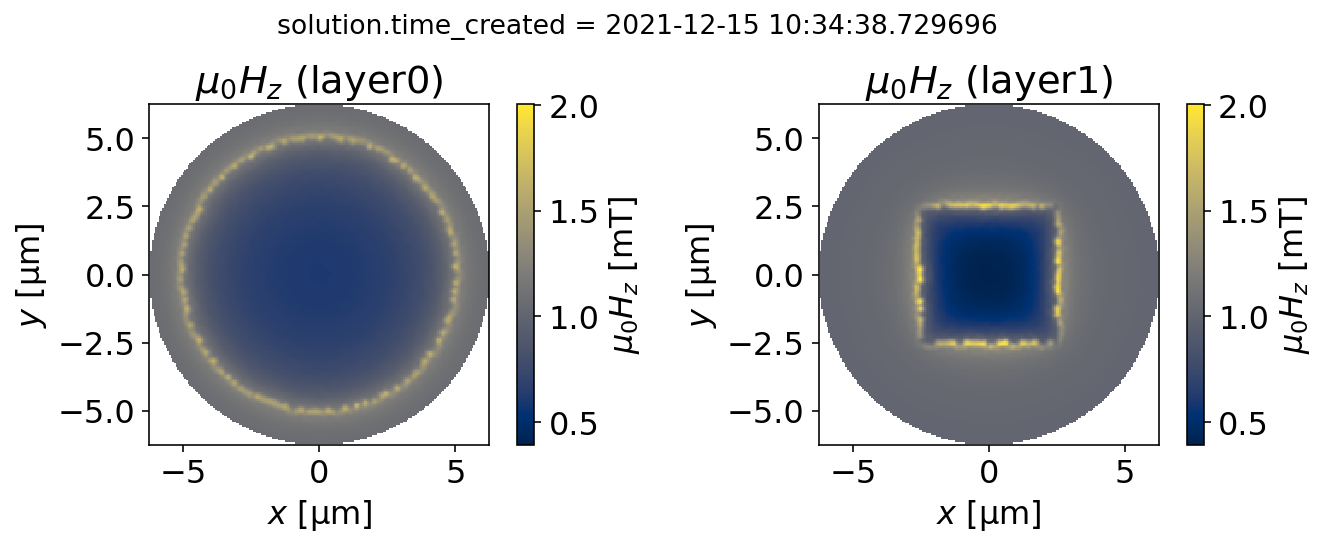

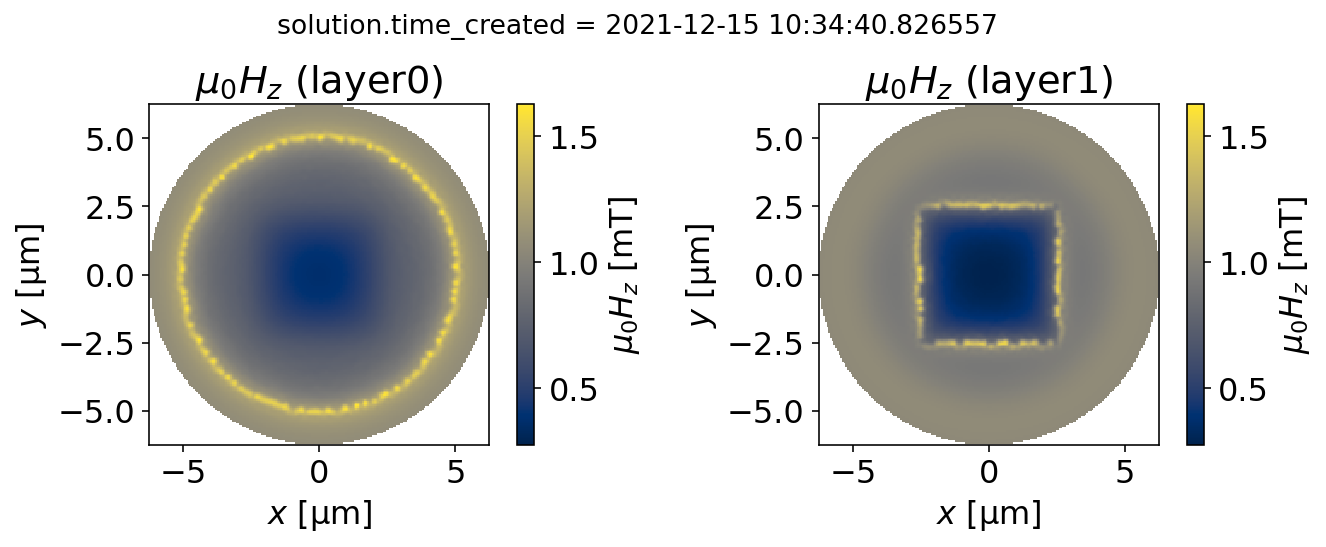

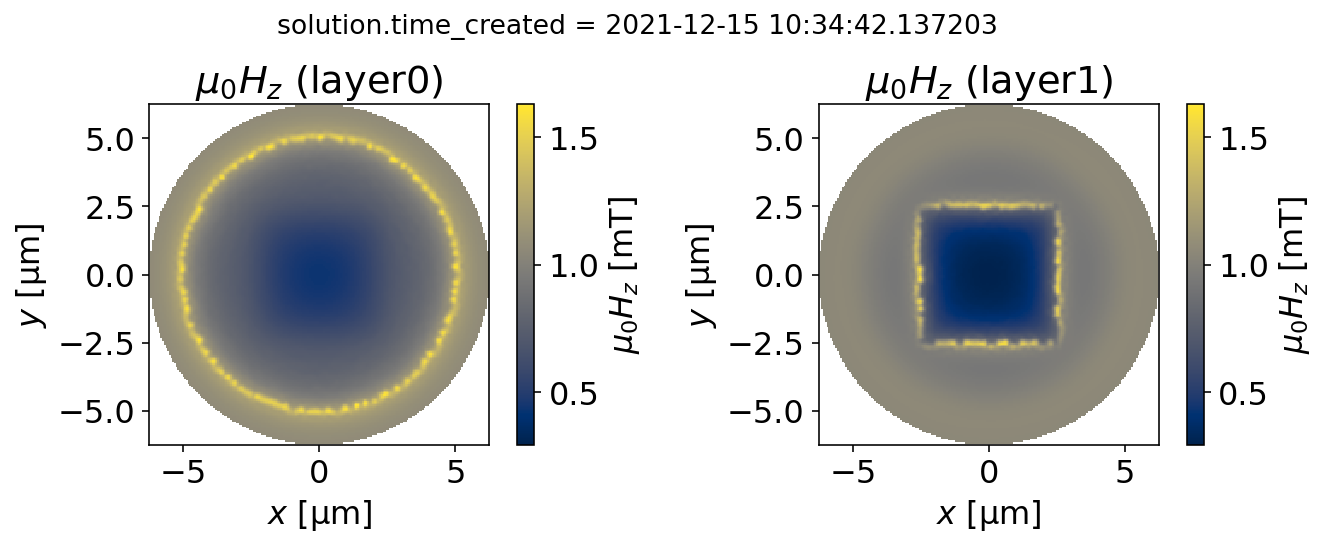

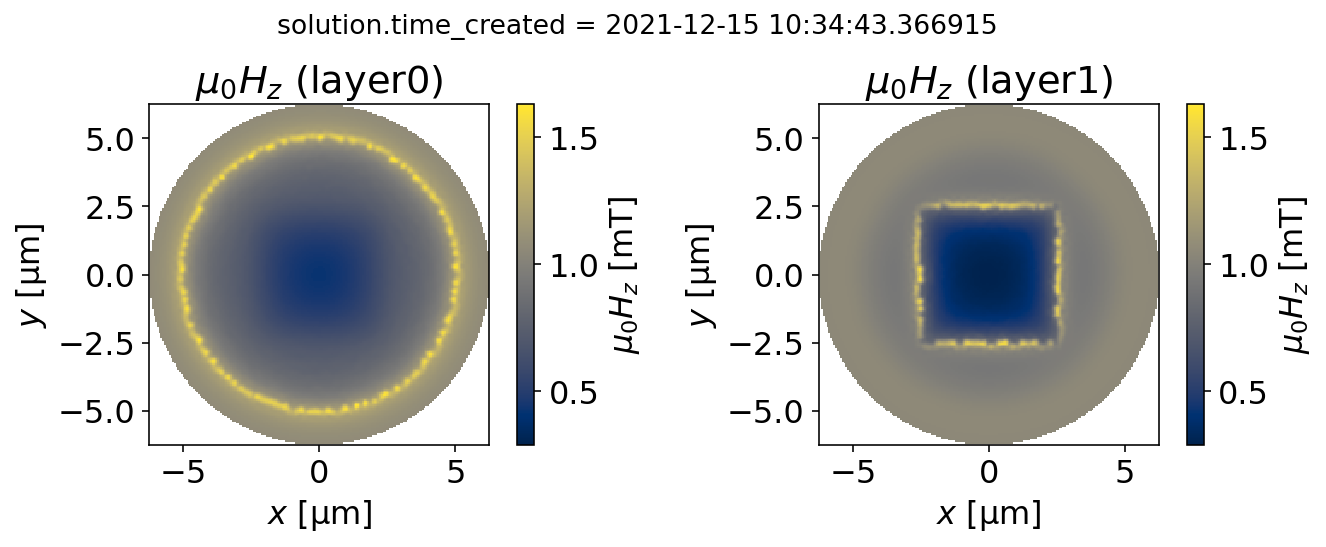

In [17]:
with tempfile.TemporaryDirectory() as directory:
    path = os.path.join(directory, "solutions")
    # Save the solutions to disk:
    sc.save_solutions(solutions, path)
    print(f"sc.iload_solutions(path) = {sc.iload_solutions(path)}\n")
    
    # Load solutions one at a time and do something with each one:
    for solution in sc.iload_solutions(path):
        fig, _ = solution.plot_fields(figsize=(11, 3.5), share_color_scale=True)
        fig.suptitle(f"solution.time_created = {solution.time_created}", fontsize="small")
        fig.subplots_adjust(top=0.8)

### Saving `Solutions` directly from `solve()`

If you want to automatically save all `Solutions` produced by a single call to `superscreen.solve()`, you can pass in a `directory` keyword argument.

```python
# Save solutions to `directory` and return them:
solutions = sc.solve(..., directory=directory)

# Save solutions to `directory` and return None:
sc.solve(..., directory=directory, return_solutions=False)
```

Below we verify that the loaded solutions are equal to the original solutions produced [above](#Saving-and-loading-multiple-Solutions) in every way other than their `time_created` attributes using the `Solution.equals()` method. `solution.equals(other_solution)` checks that the two `Solutions` have the same `Device` and boundary conditions (applied field, circulating currents, and vortices), and that their results are the same to within numerical precision. `solution.equals(other_solution, require_same_timestamp=True)` additionally requires that the `time_created` attributes of the two solutions match. Comparing two `Solutions` using the `==` operator, `solution == other_solution`, is simply shorthand for `solution.equals(other_solution, require_same_timestamp=True)`.

In [18]:
with tempfile.TemporaryDirectory() as directory:
    return_value = sc.solve(
        device,
        applied_field=sc.sources.ConstantField(1),
        field_units="mT",
        current_units="mA",
        iterations=3,
        directory=directory,
        return_solutions=False,
    )
    print(f"return_value = {return_value}")
    loaded_solutions = sc.load_solutions(directory)
    for i, (solution, loaded_solution) in enumerate(zip(solutions, loaded_solutions)):
        print(i)
        print(f"  (loaded_solution == solution) = {(loaded_solution == solution)}")
        print(
            f"  loaded_solution.equals(solution, require_same_timestamp=True) = "
            f"{loaded_solution.equals(solution, require_same_timestamp=True)}"
        )
        print(f"  loaded_solution.equals(solution) = {loaded_solution.equals(solution)}")

INFO:superscreen.solve:Calculating layer0 response to applied field.
INFO:superscreen.solve:Calculating layer1 response to applied field.
INFO:superscreen.solve:Caching 1 layer-to-layer kernel(s) (131 MB total) in memory.
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (3/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (3/3).


return_value = None
0
  (loaded_solution == solution) = False
  loaded_solution.equals(solution, require_same_timestamp=True) = False
  loaded_solution.equals(solution) = True
1
  (loaded_solution == solution) = False
  loaded_solution.equals(solution, require_same_timestamp=True) = False
  loaded_solution.equals(solution) = True
2
  (loaded_solution == solution) = False
  loaded_solution.equals(solution, require_same_timestamp=True) = False
  loaded_solution.equals(solution) = True
3
  (loaded_solution == solution) = False
  loaded_solution.equals(solution, require_same_timestamp=True) = False
  loaded_solution.equals(solution) = True
